<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/XGBoost-5/Instacart_2017_XGBoost_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Mounted at /content/drive/
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders_50.csv")
order_products_prior = pd.read_csv("op_prior_50.csv")
order_products_train = pd.read_csv("op_train_50.csv")
# orders = pd.read_csv("orders_100.csv")
# order_products_prior = pd.read_csv("op_prior_100.csv")
# order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (831792, 7)
products:  (49688, 4)
order_products_prior:  (7882503, 4)
order_products_train:  (334239, 4)


Reducing size of orders for faster computation

In [3]:
# orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 
orders.shape

(831792, 7)

In [4]:
orders.head(11)
orders[(orders['eval_set']=='train') & (orders['user_id']==1)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0


Changing some columns from object type to Category

In [5]:
order_products_train[order_products_train['order_id']==1187899]

,order_id,product_id,add_to_cart_order,reordered
116663,1187899,196,1,1
116664,1187899,25133,2,1
116665,1187899,38928,3,1
116666,1187899,26405,4,1
116667,1187899,39657,5,1
116668,1187899,10258,6,1
116669,1187899,13032,7,1
116670,1187899,26088,8,1
116671,1187899,27845,9,0
116672,1187899,49235,10,1


In [6]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [7]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (7882503, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [8]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7882503 entries, 0 to 7882502
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int64   
 5   order_hour_of_day       int64   
 6   days_since_prior_order  float64 
 7   product_id              int64   
 8   add_to_cart_order       int64   
 9   reordered               int64   
dtypes: category(1), float64(1), int64(8)
memory usage: 608.9 MB


In [9]:
op['reordered'] = op['reordered'].astype('int8')
op['order_dow'] = op['order_dow'].astype('int8')
op['order_hour_of_day'] = op['order_hour_of_day'].astype('int8')
op['add_to_cart_order'] = op['add_to_cart_order'].astype('int8')
op['days_since_prior_order'] = op['days_since_prior_order'].astype('float16')
op['user_id'] = op['user_id'].astype('int32')
op['order_id'] = op['order_id'].astype('int32')

In [10]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7882503 entries, 0 to 7882502
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
 7   product_id              int64   
 8   add_to_cart_order       int8    
 9   reordered               int8    
dtypes: category(1), float16(1), int32(2), int64(2), int8(4)
memory usage: 293.2 MB


1. USER PREDICTORS




In [11]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (49999, 1)
total users in the prior dataset = 49999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [12]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [13]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (49999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [14]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (49999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [15]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 2)


,product_id,p_total_purchases
0,1,425
1,2,27
2,3,90
3,4,68
4,6,3


In [16]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (6378825, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [17]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (4781, 2)


,product_id,p_reorder_ratio
0,1,0.571765
1,10,0.505547
2,25,0.664122
3,34,0.594628
4,45,0.660134


In [18]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,1,425,0.571765
1,2,27,NaN
2,3,90,NaN
3,4,68,NaN
4,6,3,NaN


In [19]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,425,0.571765
1,2,27,0.000000
2,3,90,0.000000
3,4,68,0.000000
4,6,3,0.000000


3. USER-PRODUCT PREDICTORS

In [20]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       196                       10
        10258                      9
        10326                      1
        12427                     10
        13032                      3

In [21]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 3)


,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [22]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (3225069, 1)


Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [23]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (49999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [24]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (3225069, 3)


,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [25]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [26]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [27]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [28]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [29]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [30]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [31]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


MERGE ALL FEATURES

In [32]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915
3,1,12427,10,1.000000,10,0.694915
4,1,13032,3,0.333333,10,0.694915


In [33]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,9271,0.788264
1,1,10258,9,1.000000,10,0.694915,469,0.707889
2,1,10326,1,0.166667,10,0.694915,1220,0.618852
3,1,12427,10,1.000000,10,0.694915,1586,0.734552
4,1,13032,3,0.333333,10,0.694915,877,0.638540


In [34]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

152

TRAIN DF

In [35]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (831792, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [36]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (7882503, 10)


,user_id,product_id,reordered
0,1,196,0
1,1,14084,0
2,1,12427,0
3,1,26088,0
4,1,26405,0
5,1,196,1
6,1,10258,0
7,1,12427,1
8,1,13176,0
9,1,26088,1


In [37]:
op = op.groupby(['user_id','product_id'])['reordered'].sum()

op = op.reset_index()
# op3 = op3[op3['new_reorder'] > 0]

# new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
op['reordered'] = op['reordered'].apply(lambda x: 0 if x == 0 else 1)
op.head(20)
op.shape

(3225069, 3)

In [38]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (3225069, 9)


In [39]:
del op

In [40]:
opjoin.head(40)

,user_id,product_id,reordered,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,1,10,1.000000,10,0.694915,9271,0.788264
1,1,10258,1,9,1.000000,10,0.694915,469,0.707889
2,1,10326,0,1,0.166667,10,0.694915,1220,0.618852
3,1,12427,1,10,1.000000,10,0.694915,1586,0.734552
4,1,13032,1,3,0.333333,10,0.694915,877,0.638540
5,1,13176,1,2,0.222222,10,0.694915,92533,0.833454
6,1,14084,0,1,0.100000,10,0.694915,4101,0.812729
7,1,17122,0,1,0.166667,10,0.694915,3197,0.655302
8,1,25133,1,8,1.000000,10,0.694915,1461,0.737166
9,1,26088,1,2,0.200000,10,0.694915,633,0.556082


In [41]:
opjoin['reordered'].unique()

array([1, 0])

In [42]:
opjoin = opjoin.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [43]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head(11)

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       196                 1           1.000000           0.694915   
        10258               1           1.000000           0.694915   
        10326               0           0.166667           0.694915   
        12427               1           1.000000           0.694915   
        13032               1           0.333333           0.694915   
        13176               1           0.222222           0.694915   
        14084               0           0.100000           0.694915   
        17122               0           0.166667           0.694915   
        25133               1           1.000000           0.694915   
        26088               1           0.200000           0.694915   
        26405               1           0.200000           0.694915   

                    p_reorder_ratio  
user_id product_id                   
1       196                0.788264  
        10258              0.707889  
        10326              0.618852  
        12427              0.734552  
        13032              0.638540  
        13176              0.833454  
        14084              0.812729  
        17122              0.655302  
        25133              0.737166  
        26088              0.556082  
        26405              0.395189

In [44]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3225069 entries, (1, 196) to (49999, 49683)
Data columns (total 4 columns):
 #   Column             Dtype  
---  ------             -----  
 0   reordered          int64  
 1   uxp_reorder_ratio  float64
 2   u_reordered_ratio  float64
 3   p_reorder_ratio    float64
dtypes: float64(3), int64(1)
memory usage: 125.8 MB


In [45]:
opjoin.head(20)

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       196                 1           1.000000           0.694915   
        10258               1           1.000000           0.694915   
        10326               0           0.166667           0.694915   
        12427               1           1.000000           0.694915   
        13032               1           0.333333           0.694915   
        13176               1           0.222222           0.694915   
        14084               0           0.100000           0.694915   
        17122               0           0.166667           0.694915   
        25133               1           1.000000           0.694915   
        26088               1           0.200000           0.694915   
        26405               1           0.200000           0.694915   
        30450               0           0.125000           0.694915   
        35951               0           1.000000           0.694915   
        38928               0           1.000000           0.694915   
        39657               0           1.000000           0.694915   
        41787               0           0.166667           0.694915   
        46149               1           1.000000           0.694915   
        49235               1           0.666667           0.694915   
2       23                  0           0.142857           0.476923   
        79                  0           0.500000           0.476923   

                    p_reorder_ratio  
user_id product_id                   
1       196                0.788264  
        10258              0.707889  
        10326              0.618852  
        12427              0.734552  
        13032              0.638540  
        13176              0.833454  
        14084              0.812729  
        17122              0.655302  
        25133              0.737166  
        26088              0.556082  
        26405              0.395189  
        30450              0.594628  
        35951              0.751962  
        38928              0.828919  
        39657              0.758176  
        41787              0.651804  
        46149              0.804134  
        49235              0.773240  
2       23                 0.000000  
        79                 0.490066

TEST DF 

In [46]:
order_products_train = order_products_train[order_products_train['reordered']==1]
print('order_products_train.shape =', order_products_train)
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

order_products_train.shape =         order_id  product_id  add_to_cart_order  reordered
3             38       21616                  4          1
9             96       20574                  1          1
11            96       40706                  3          1
13            96       27966                  5          1
14            96       24489                  6          1
...          ...         ...                ...        ...
334230   3420996       24035                  3          1
334233   3420996       14947                  6          1
334234   3420996        2086                  7          1
334236   3420996       27423                  9          1
334237   3420996       12125                 10          1

[201191 rows x 4 columns]
op_test.shape (201191, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [47]:
op_test = op_test.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [48]:
op_test[op_test['user_id']==1]

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [49]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (201191, 3)


,user_id,product_id,expected_y
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1


In [50]:
opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin_test.shape =', opjoin_test.shape)

opjoin_test.shape = (201191, 9)


In [51]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head(12)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,9271,0.788264
1,1,25133,8,1.000000,10,0.694915,1461,0.737166
2,1,38928,1,1.000000,10,0.694915,3285,0.828919
3,1,26405,2,0.200000,10,0.694915,291,0.395189
4,1,39657,1,1.000000,10,0.694915,1162,0.758176
5,1,10258,9,1.000000,10,0.694915,469,0.707889
6,1,13032,3,0.333333,10,0.694915,877,0.638540
7,1,26088,2,0.200000,10,0.694915,633,0.556082
8,1,49235,2,0.666667,10,0.694915,17384,0.773240
9,1,46149,3,1.000000,10,0.694915,2032,0.804134


In [52]:
opjoin_test = opjoin_test.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [53]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head()

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio
user_id product_id                                                       
1       196                       1.0           0.694915         0.788264
        25133                     1.0           0.694915         0.737166
        38928                     1.0           0.694915         0.828919
        26405                     0.2           0.694915         0.395189
        39657                     1.0           0.694915         0.758176

Build Model

In [54]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [55]:
opjoin.head()

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       196                 1           1.000000           0.694915   
        10258               1           1.000000           0.694915   
        10326               0           0.166667           0.694915   
        12427               1           1.000000           0.694915   
        13032               1           0.333333           0.694915   

                    p_reorder_ratio  
user_id product_id                   
1       196                0.788264  
        10258              0.707889  
        10326              0.618852  
        12427              0.734552  
        13032              0.638540

In [56]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[0]	train-logloss:0.65903
[10]	train-logloss:0.508602
[20]	train-logloss:0.440922
[30]	train-logloss:0.409391
[40]	train-logloss:0.389999
[50]	train-logloss:0.371179
[60]	train-logloss:0.362315
[70]	train-logloss:0.355048
[79]	train-logloss:0.348816


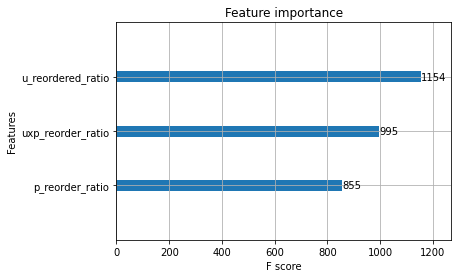

In [57]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [58]:
del [X_train, X_val, y_train, y_val]
gc.collect()

50

In [59]:
opjoin_test.head()

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio
user_id product_id                                                       
1       196                       1.0           0.694915         0.788264
        25133                     1.0           0.694915         0.737166
        38928                     1.0           0.694915         0.828919
        26405                     0.2           0.694915         0.395189
        39657                     1.0           0.694915         0.758176

In [60]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,196,1,1
1,25133,1,1
2,38928,1,1
3,26405,1,1
4,39657,1,1
...,...,...,...
201186,10644,49999,1
201187,26629,49999,1
201188,20980,49999,1
201189,7728,49999,1


In [61]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,1,1
3,26405,1,1,1
4,39657,1,1,1


In [62]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,1,1
3,26405,1,1,1
4,39657,1,1,1
5,10258,1,1,1
6,13032,1,1,1
7,26088,1,1,1
8,49235,1,1,1
9,46149,1,1,1


In [63]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,1,1,True
3,26405,1,1,1,True
4,39657,1,1,1,True


In [64]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201191 entries, 0 to 201190
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   product_id           201191 non-null  int64
 1   user_id              201191 non-null  int64
 2   reordered_predicted  201191 non-null  int64
 3   expected_y           201191 non-null  int64
 4   compare              201191 non-null  bool 
dtypes: bool(1), int64(4)
memory usage: 7.9 MB


In [65]:
true_count = tally['compare'].sum()
true_count

180505

In [66]:
false_count = len(tally['compare'])
false_count

201191

In [67]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 89.7182279525426 %


In [68]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,1,1,True
3,26405,1,1,1,True
4,39657,1,1,1,True
5,10258,1,1,1,True
6,13032,1,1,1,True
7,26088,1,1,1,True
8,49235,1,1,1,True
9,46149,1,1,1,True


In [69]:
orders[(orders['user_id']==7) & (orders['eval_set']=='train')]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
74,525192,7,train,21,2,11,6.0


In [70]:
order_products_train[order_products_train['order_id']==525192]

,order_id,product_id,add_to_cart_order,reordered
51990,525192,47272,2,1
51991,525192,37999,3,1
51992,525192,13198,4,1
51993,525192,43967,5,1
51994,525192,40852,6,1
51995,525192,17638,7,1
51996,525192,29894,8,1
51997,525192,45066,9,1
